## Classical Decomposition Model

$$
    X_t = m_t + s_t + Y_t, \ \ 1 \leq t \leq n
$$
where $E[Y_t] = 0$, $s_t = s_{t + d}$ and $\sum_{i = 1}^{d} s_i = 0$. 

This is an implementation of the method outlined in Brockwell and Davis (Chapter 1, Section 5.2)

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def f(w):
    def g(x):
        return (x * w).sum() / (len(w) - 1)
    return g

def calculate_initial_trend(x, d):
    assert d > 0
    
    if d % 2 == 0:
        wts = [0.5] + [1] * (d - 1) + [0.5]
        return x.rolling(window = d + 1, center = True).apply(f(wts))
    
    return x.rolling(window = d, center = True).mean()

def estimate_seasonal_component(x, d):
    ini_trend = calculate_initial_trend(x, d)
    diff = x - ini_trend
    n = len(x)
    
    if d % 2 == 0:
        q = d // 2
    else:
        q = (d - 1) // 2
    
    # this is the vector that will hold the seasonality values    
    w = np.zeros(d)
    
    # these are the starting points for the d seasonality components
    st = [q + k for k in range(0, d)]
    
    for k in range(0, d):
        # these are the indices for the kth seasonality component
        i = st[k]
        indices = []
        
        while (i < n - q):
            indices += [i]
            i += d
        
        for idx in indices:
            w[k] += diff[idx]
    
    mu = np.mean(w)
    return (w - mu), q      

def trend_exp_smooth(x, alpha):
    ret = np.ones(len(x))
    ret[0] = x[0]
    
    for t in np.arange(1, len(x), 1):
        first = [alpha * (1 - alpha)**j * x[t - j] for j in range(0, t)]
        ret[t] = np.sum(first) + (1 - alpha)**t * x[0]
        
    return list(ret)

def est_trend_seasonality(x, d, alpha):
    season_d, start_idx = estimate_seasonal_component(x, d)
    
    div = len(x) // d
    rem = len(x) % d
    
    seasonality = list(season_d) * div  + list(season_d)[: rem]
    
    print(len(x))
    print(len(seasonality))
    assert len(seasonality) == len(x)
    
    trend = trend_exp_smooth(x - seasonality, alpha)
    
    return seasonality, trend, x - seasonality - trend

In [60]:
df = pd.DataFrame(columns=['x'])
df['x'] = [i for i in range(1, 11)]

In [61]:
df

,x
0,1
1,2
2,3
3,4
4,5
5,6
6,7
7,8
8,9
9,10


In [62]:
seasonality = estimate_seasonal_component(df['x'], d=4)

/home/somnath/Envs/env3.6/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  from ipykernel import kernelapp as app


In [63]:
seasonality

(array([0., 0., 0., 0.]), 2)

In [64]:
deaths = pd.read_csv("../../data/CSV/deaths.csv")

In [65]:
deaths.head()

,month,year,deaths
0,1,1973,9007
1,2,1973,8106
2,3,1973,8928
3,4,1973,9137
4,5,1973,10017


In [66]:
# using day == 1 for converting month, year to datetime objects. Merely a convenience
deaths['day'] = [1] * len(deaths)
deaths['date'] = pd.to_datetime(deaths[['year','month', 'day']])

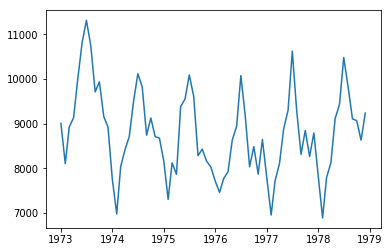

In [67]:
plt.plot(deaths['date'], deaths['deaths'])

In [68]:
seasonality, trend, noise = est_trend_seasonality(deaths['deaths'], d=12, alpha=0.2)

72
72


/home/somnath/Envs/env3.6/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  from ipykernel import kernelapp as app


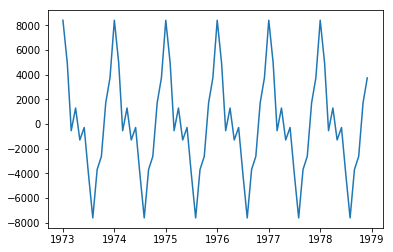

In [69]:
plt.plot(deaths['date'], seasonality)

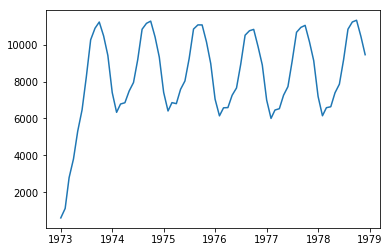

In [70]:
plt.plot(deaths['date'], trend)

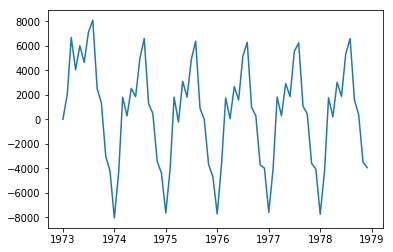

In [71]:
plt.plot(deaths['date'], noise)

In [72]:
type(deaths['deaths'] - seasonality)

pandas.core.series.Series

## Elimination of Seasonality by Differencing

If $X_t = m_t + s_t + Y_t$, where $s_t$ is a seasonaility component with period $d$, then a lag-$d$ differencing operator $\nabla_d$ applied to $X_t$ yields:
$$
    \nabla_d(X_t) = m_t - m_{t - d} + s_{t} - s_{t - d} + Y_t - Y_{t - d} = m_t - m_{t - d} + Y_t - Y_{t - d}
$$

In [73]:
deaths['lag_12'] = deaths['deaths'].diff(periods=12)

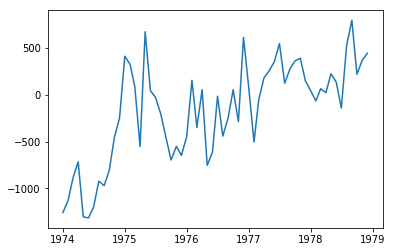

In [74]:
plt.plot(deaths['date'], deaths['lag_12'])

### Double Differencing

Can be shown that $\nabla \nabla_d (X_t)$ can be represented by a stationary time series model. 

In [75]:
deaths['lag_lag_12'] = deaths['lag_12'].diff(periods=1)

In [76]:
deaths['lag_lag_12'][:14, ]

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
5       NaN
6       NaN
7       NaN
8       NaN
9       NaN
10      NaN
11      NaN
12      NaN
13    132.0
Name: lag_lag_12, dtype: float64

In [77]:
deaths['lag_lag_12'] = deaths['lag_lag_12'].fillna(method='bfill')

In [78]:
deaths['lag_lag_12'][:14, ]

0     132.0
1     132.0
2     132.0
3     132.0
4     132.0
5     132.0
6     132.0
7     132.0
8     132.0
9     132.0
10    132.0
11    132.0
12    132.0
13    132.0
Name: lag_lag_12, dtype: float64

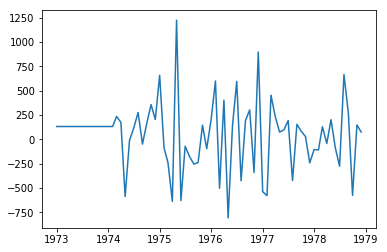

In [79]:
plt.plot(deaths['date'], deaths['lag_lag_12'])